In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from deep_fields.data.crypto.create_dataset_files import read_and_fix
from deep_fields.models.crypto.portfolio_selection import ml_estimates_black_scholes_from_predictors
from deep_fields.models.crypto.predictors import CryptoSeq2Seq
from deep_fields.data.crypto.dataloaders import CryptoDataLoader,PortfolioDataLoader
from deep_fields import data_path

In [2]:
#===================================================
# SELECT DATALOADER
#===================================================
date_string = "2021-06-14"
crypto_folder = os.path.join(data_path, "raw", "crypto")
data_folder = os.path.join(crypto_folder, date_string)

kwargs = {"path_to_data":data_folder,
          "batch_size": 29,
          "steps_ahead":14,
          "date_string": date_string,
          "clean":"interpol",
          "span":"full"}

crypto_data_loader = CryptoDataLoader('cpu', **kwargs)
data_loader = PortfolioDataLoader('cpu', **kwargs)
train_data_batch = next(data_loader.train.__iter__())

In [3]:
#===================================================
# SELECT PREDICTOR
#===================================================
model_dir="C:/Users/cesar/Desktop/Projects/General/deep_random_fields/results/crypto_seq2seq/1637576663/"
cs2s = CryptoSeq2Seq(model_dir=model_dir)
output, unfolded_series = cs2s(train_data_batch)
print(output.shape)
print(unfolded_series.shape)

Loading Model No Inference
torch.Size([29, 2345, 13, 3])
torch.Size([29, 2345, 14, 3])


In [4]:
start_ = 10
end_ = 1
mu_stats = []
sigma_stats = []
returns_stats = []
ids_ = []
for j,train_data_batch in enumerate(data_loader.train):
    print("{0} out of {1}".format(j,data_loader.n_train_batches))
    output, unfolded_series = cs2s(train_data_batch)
    mu_ml, sigma_square_ml = ml_estimates_black_scholes_from_predictors(output)
    mu_av = mu_ml[:,-start_:-end_].mean(axis=1)
    sigma_av = sigma_square_ml[:,-10:-1].mean(axis=1)
    
    mu_stats.extend(mu_av.detach().numpy().tolist())
    sigma_stats.extend(sigma_av.detach().numpy().tolist())
    ids_.extend(train_data_batch.ids.detach().tolist())
    
    prices = output[:, :, :-1, 0]
    prices_ahead = output[:, :, 1:, 0]
    portfolio_returns = (prices_ahead - prices) / prices
    returns_stats.extend(portfolio_returns[:,-1,:].mean(axis=1).detach().numpy().tolist())

0 out of 146
1 out of 146
2 out of 146
3 out of 146
4 out of 146
5 out of 146
6 out of 146
7 out of 146
8 out of 146
9 out of 146
10 out of 146
11 out of 146
12 out of 146
13 out of 146
14 out of 146
15 out of 146
16 out of 146
17 out of 146
18 out of 146
19 out of 146
20 out of 146
21 out of 146
22 out of 146
23 out of 146
24 out of 146
25 out of 146
26 out of 146
27 out of 146
28 out of 146
29 out of 146
30 out of 146
31 out of 146
32 out of 146
33 out of 146
34 out of 146
35 out of 146
36 out of 146
37 out of 146
38 out of 146
39 out of 146
40 out of 146
41 out of 146
42 out of 146
43 out of 146
44 out of 146
45 out of 146
46 out of 146
47 out of 146
48 out of 146
49 out of 146
50 out of 146
51 out of 146
52 out of 146
53 out of 146
54 out of 146
55 out of 146
56 out of 146
57 out of 146
58 out of 146
59 out of 146
60 out of 146
61 out of 146
62 out of 146
63 out of 146
64 out of 146
65 out of 146
66 out of 146
67 out of 146
68 out of 146
69 out of 146
70 out of 146
71 out of 146
72

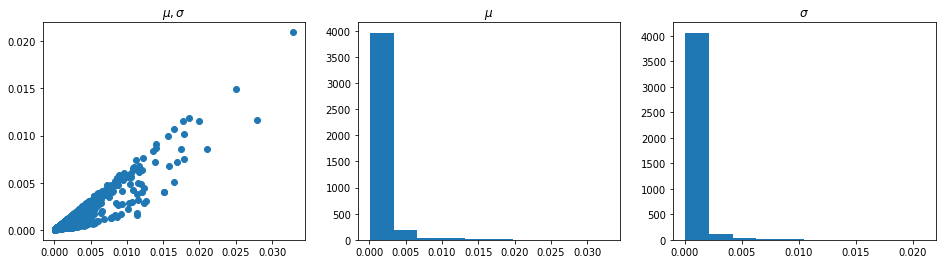

In [5]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(16,4))
ax[0].set_title(r"$\mu,\sigma$")
ax[0].scatter(mu_stats,sigma_stats)
ax[1].set_title(r"$\mu$")
stuff = ax[1].hist(mu_stats)
ax[2].set_title(r"$\sigma$")
stuff = ax[2].hist(sigma_stats,)

In [15]:
returns_and_ids = [(s,r,i) for r,s,i in zip(returns_stats,sigma_stats,ids_)]
returns_and_ids.sort()
top_returns = returns_and_ids[::-1][:10]
top_id = [a[2] for a in top_returns]

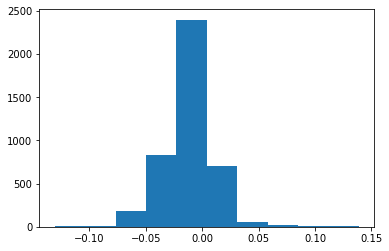

In [16]:
stuff = plt.hist(returns_stats)

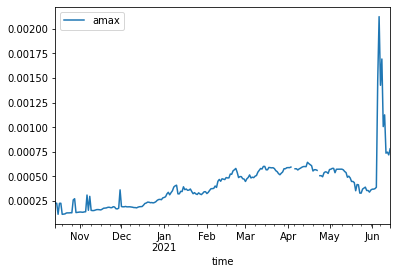

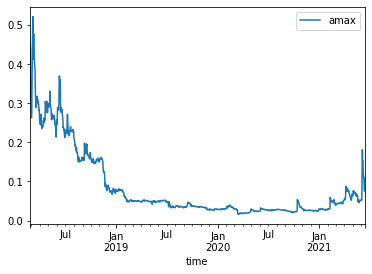

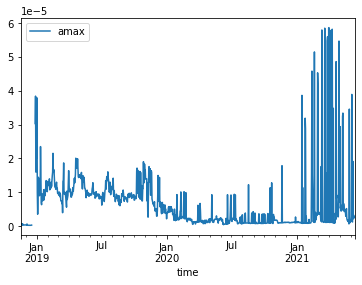

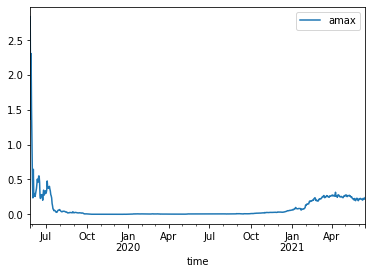

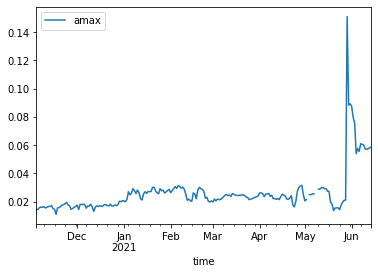

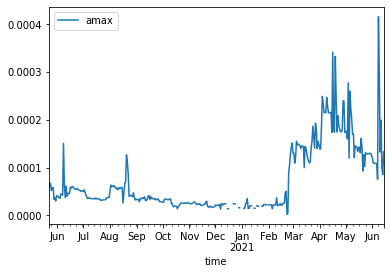

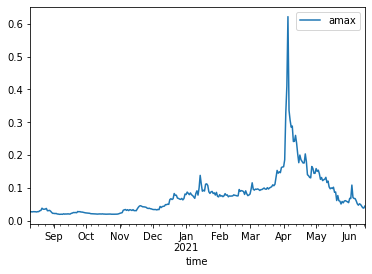

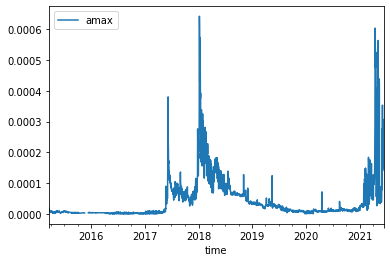

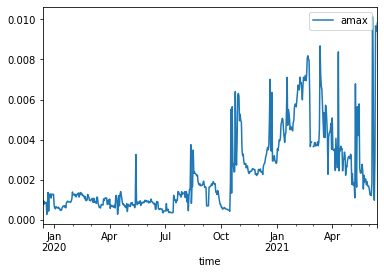

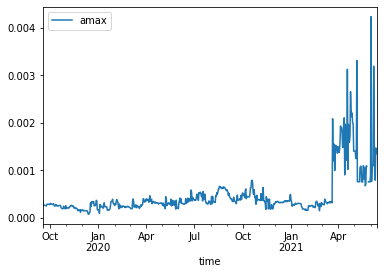

In [19]:
for top_id_ in top_id:
    id_string = crypto_data_loader.meta_ecosystem[top_id_]["id"]
    coind_df = read_and_fix(data_folder,coin_file_name="{0}_full.csv".format(id_string),span="full")
    coind_df["price"].plot()

In [10]:
def excess_return_daily(policy_evaluated, data_loader, start=0, end=None, steps_ahead=1):
    portfolio_pmv = data_loader.portfolio_pmv[:,start:end,:]
    prices = portfolio_pmv[:, :-steps_ahead, 0]

    unfolded_portfolio_pmv = portfolio_pmv.unfold(dimension=1,
                                                  size=steps_ahead + 1,
                                                  step=1).contiguous()
    unfolded_prices = unfolded_portfolio_pmv[:, :, 0, :]
    prices_ahead = unfolded_prices[:, :, -1]
    portfolio_returns = (prices_ahead - prices) / prices

    assert policy_evaluated.shape == portfolio_returns.shape

    policy_evaluated = policy_evaluated * portfolio_returns
    policy_evaluated[policy_evaluated != policy_evaluated] = 0.

    excess_return = 1. + policy_evaluated.sum(axis=0)
    excess_return = excess_return[torch.arange(0,excess_return.shape[0],steps_ahead).long()]
    excess_return_ = torch.prod(excess_return)

    return excess_return_